# Initial Setup

In [4]:
import os
import io
import pprint
import tempfile
import matplotlib
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from PIL import Image
from six import BytesIO
from IPython import display
from urllib.request import urlopen

In [6]:
import orbit
import tensorflow_models as tfm

from tensorflow.python.framework.config import set_memory_growth
from official.core import exp_factory
from official.core import config_definitions as cfg
from official.vision.serving import export_saved_model_lib
from official.vision.ops.preprocess_ops import normalize_image
from official.vision.ops.preprocess_ops import resize_and_crop_image
from official.vision.utils.object_detection import visualization_utils
from official.vision.dataloaders.tf_example_decoder import TfExampleDecoder

pp = pprint.PrettyPrinter(indent=4) # Set Pretty Print Indentation
print(tf.__version__) # Check the version of tensorflow used

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
        tf.config.experimental.set_memory_growth(gpus[0], True)

%matplotlib inline

2.16.1


# TFRecords

## Train Model

In [3]:
%%bash

TRAIN_DATA_DIR="./PlayingCards.v4-yolov8n.coco/train"
TRAIN_ANNOTATION_FILE_DIR="./PlayingCards.v4-yolov8n.coco/train/_annotations.coco.json"
OUTPUT_TFRECORD_TRAIN="./tfRecords/train"

python -m official.vision.data.create_coco_tf_record --logtostderr \
    --image_dir=${TRAIN_DATA_DIR} \
    --object_annotations_file=${TRAIN_ANNOTATION_FILE_DIR} \
    --output_file_prefix=${OUTPUT_TFRECORD_TRAIN} \
    --num_shards=1

2024-05-12 03:53:45.244040: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-12 03:53:47.728418: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: UNKNOWN ERROR (34)
I0512 03:53:47.729852 140027194343424 create_coco_tf_record.py:502] writing to output path: ./tfRecords/train
I0512 03:53:48.663127 140027194343424 create_coco_tf_record.py:374] Building bounding box index.
I0512 03:53:48.684215 140027194343424 create_coco_tf_record.py:385] 0 images are missing bboxes.
I0512 03:54:10.768291 140027194343424 tfrecord_lib.py:168] On image 0
I0512 03:54:10.830569 140027194343424 tfrecord_lib.py:168] On image 100
I0512 03:54:10.889368 140027194343424 tfrecord_lib.py:168] On image 200
I0512 03:54:10.941183 140027194343

## Test Model

In [4]:
%%bash

TRAIN_DATA_DIR="./PlayingCards.v4-yolov8n.coco/test"
TRAIN_ANNOTATION_FILE_DIR="./PlayingCards.v4-yolov8n.coco/test/_annotations.coco.json"
OUTPUT_TFRECORD_TRAIN="./tfRecords/test"

python -m official.vision.data.create_coco_tf_record --logtostderr \
    --image_dir=${TRAIN_DATA_DIR} \
    --object_annotations_file=${TRAIN_ANNOTATION_FILE_DIR} \
    --output_file_prefix=${OUTPUT_TFRECORD_TRAIN} \
    --num_shards=1

2024-05-12 03:54:26.087739: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-12 03:54:28.725425: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: UNKNOWN ERROR (34)
I0512 03:54:28.726394 140121761177600 create_coco_tf_record.py:502] writing to output path: ./tfRecords/test
I0512 03:54:28.769805 140121761177600 create_coco_tf_record.py:374] Building bounding box index.
I0512 03:54:28.771229 140121761177600 create_coco_tf_record.py:385] 0 images are missing bboxes.
I0512 03:54:29.928301 140121761177600 tfrecord_lib.py:168] On image 0
I0512 03:54:29.969087 140121761177600 tfrecord_lib.py:168] On image 100
I0512 03:54:30.010510 140121761177600 tfrecord_lib.py:168] On image 200
I0512 03:54:30.054916 1401217611776

## Valid Model

In [5]:
%%bash

TRAIN_DATA_DIR="./PlayingCards.v4-yolov8n.coco/valid"
TRAIN_ANNOTATION_FILE_DIR="./PlayingCards.v4-yolov8n.coco/valid/_annotations.coco.json"
OUTPUT_TFRECORD_TRAIN="./tfRecords/valid"

python -m official.vision.data.create_coco_tf_record --logtostderr \
    --image_dir=${TRAIN_DATA_DIR} \
    --object_annotations_file=${TRAIN_ANNOTATION_FILE_DIR} \
    --output_file_prefix=${OUTPUT_TFRECORD_TRAIN} \
    --num_shards=1

2024-05-12 03:54:34.962320: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-12 03:54:37.454464: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: UNKNOWN ERROR (34)
I0512 03:54:37.455477 140188746162176 create_coco_tf_record.py:502] writing to output path: ./tfRecords/valid
I0512 03:54:37.631212 140188746162176 create_coco_tf_record.py:374] Building bounding box index.
I0512 03:54:37.632724 140188746162176 create_coco_tf_record.py:385] 0 images are missing bboxes.
I0512 03:54:39.736104 140188746162176 tfrecord_lib.py:168] On image 0
I0512 03:54:39.785863 140188746162176 tfrecord_lib.py:168] On image 100
I0512 03:54:39.828065 140188746162176 tfrecord_lib.py:168] On image 200
I0512 03:54:39.873602 140188746162

# MLModel

In [7]:
train_data_input_path = './tfRecords/train-00000-of-00001.tfrecord'
valid_data_input_path = './tfRecords/valid-00000-of-00001.tfrecord'
test_data_input_path = './tfRecords/test-00000-of-00001.tfrecord'
model_dir = './trained_model/'
export_dir ='./exported_model/'

In [8]:
exp_config = exp_factory.get_exp_config('retinanet_resnetfpn_coco')

In [19]:
batch_size = 4
num_classes = 52

HEIGHT, WIDTH = 640, 640
IMG_SIZE = [HEIGHT, WIDTH, 3]

# Backbone config.
exp_config.task.freeze_backbone = False
exp_config.task.annotation_file = ''

# Model config.
exp_config.task.model.input_size = IMG_SIZE
exp_config.task.model.num_classes = num_classes + 1
exp_config.task.model.detection_generator.tflite_post_processing.max_classes_per_detection = exp_config.task.model.num_classes

# Training data config.
exp_config.task.train_data.input_path = train_data_input_path
exp_config.task.train_data.dtype = 'float32'
exp_config.task.train_data.global_batch_size = batch_size
exp_config.task.train_data.parser.aug_scale_max = 1.0
exp_config.task.train_data.parser.aug_scale_min = 1.0

# Validation data config.
exp_config.task.validation_data.input_path = valid_data_input_path
exp_config.task.validation_data.dtype = 'float32'
exp_config.task.validation_data.global_batch_size = batch_size

In [20]:
logical_device_names = [logical_device.name for logical_device in tf.config.list_logical_devices()]

if 'GPU' in ''.join(logical_device_names):
  print('This may be broken in Colab.')
  device = 'GPU'
elif 'TPU' in ''.join(logical_device_names):
  print('This may be broken in Colab.')
  device = 'TPU'
else:
  print('Running on CPU is slow, so only train for a few steps.')
  device = 'CPU'


train_steps = 1000
exp_config.trainer.steps_per_loop = 100 # steps_per_loop = num_of_training_examples // train_batch_size

exp_config.trainer.summary_interval = 100
exp_config.trainer.checkpoint_interval = 100
exp_config.trainer.validation_interval = 100
exp_config.trainer.validation_steps =  100 # validation_steps = num_of_validation_examples // eval_batch_size
exp_config.trainer.train_steps = train_steps
exp_config.trainer.optimizer_config.warmup.linear.warmup_steps = 100
exp_config.trainer.optimizer_config.learning_rate.type = 'cosine'
exp_config.trainer.optimizer_config.learning_rate.cosine.decay_steps = train_steps
exp_config.trainer.optimizer_config.learning_rate.cosine.initial_learning_rate = 0.1
exp_config.trainer.optimizer_config.warmup.linear.warmup_learning_rate = 0.05

This may be broken in Colab.


In [21]:
pp.pprint(exp_config.as_dict())
display.Javascript('google.colab.output.setIframeHeight("500px");')

{   'runtime': {   'all_reduce_alg': None,
                   'batchnorm_spatial_persistent': False,
                   'dataset_num_private_threads': None,
                   'default_shard_dim': -1,
                   'distribution_strategy': 'mirrored',
                   'enable_xla': False,
                   'gpu_thread_mode': None,
                   'loss_scale': None,
                   'mixed_precision_dtype': 'bfloat16',
                   'num_cores_per_replica': 1,
                   'num_gpus': 0,
                   'num_packs': 1,
                   'per_gpu_thread_count': 0,
                   'run_eagerly': False,
                   'task_index': -1,
                   'tpu': None,
                   'tpu_enable_xla_dynamic_padder': None,
                   'use_tpu_mp_strategy': False,
                   'worker_hosts': None},
    'task': {   'allow_image_summary': False,
                'annotation_file': '',
                'differential_privacy_config': None,
     

<IPython.core.display.Javascript object>

In [22]:
if exp_config.runtime.mixed_precision_dtype == tf.float16:
    tf.keras.mixed_precision.set_global_policy('mixed_float16')

if 'GPU' in ''.join(logical_device_names):
  distribution_strategy = tf.distribute.MirroredStrategy()
elif 'TPU' in ''.join(logical_device_names):
  tf.tpu.experimental.initialize_tpu_system()
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='/device:TPU_SYSTEM:0')
  distribution_strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
  print('Warning: this will be really slow.')
  distribution_strategy = tf.distribute.OneDeviceStrategy(logical_device_names[0])

print('Done')

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


Done


In [23]:
with distribution_strategy.scope():
  task = tfm.core.task_factory.get_task(exp_config.task, logging_dir=model_dir)

In [24]:
for images, labels in task.build_inputs(exp_config.task.train_data).take(1):
  print()
  print(f'images.shape: {str(images.shape):16}  images.dtype: {images.dtype!r}')
  print(f'labels.keys: {labels.keys()}')


images.shape: (4, 640, 640, 3)  images.dtype: tf.float32
labels.keys: dict_keys(['cls_targets', 'box_targets', 'anchor_boxes', 'cls_weights', 'box_weights', 'image_info'])


2024-05-12 06:13:50.522659: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [25]:
category_index={
    1: {
        'id': 1,
        'name': 'AS'
       },
    2: {
        'id': 2,
        'name': '2S'
       },
    3: {
        'id': 3,
        'name': '3S'
       }
}
tf_ex_decoder = TfExampleDecoder()

In [26]:
def show_batch(raw_records, num_of_examples):
  plt.figure(figsize=(20, 20))
  use_normalized_coordinates=True
  min_score_thresh = 0.30
  for i, serialized_example in enumerate(raw_records):
    plt.subplot(1, 3, i + 1)
    decoded_tensors = tf_ex_decoder.decode(serialized_example)
    image = decoded_tensors['image'].numpy().astype('uint8')
    scores = np.ones(shape=(len(decoded_tensors['groundtruth_boxes'])))
    visualization_utils.visualize_boxes_and_labels_on_image_array(
        image,
        decoded_tensors['groundtruth_boxes'].numpy(),
        decoded_tensors['groundtruth_classes'].numpy().astype('int'),
        scores,
        category_index=category_index,
        use_normalized_coordinates=use_normalized_coordinates,
        max_boxes_to_draw=200,
        min_score_thresh=min_score_thresh,
        agnostic_mode=False,
        instance_masks=None,
        line_thickness=4)

    plt.imshow(image)
    plt.axis('off')
    plt.title(f'Image-{i+1}')
  plt.show()

2024-05-12 06:13:50.705560: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


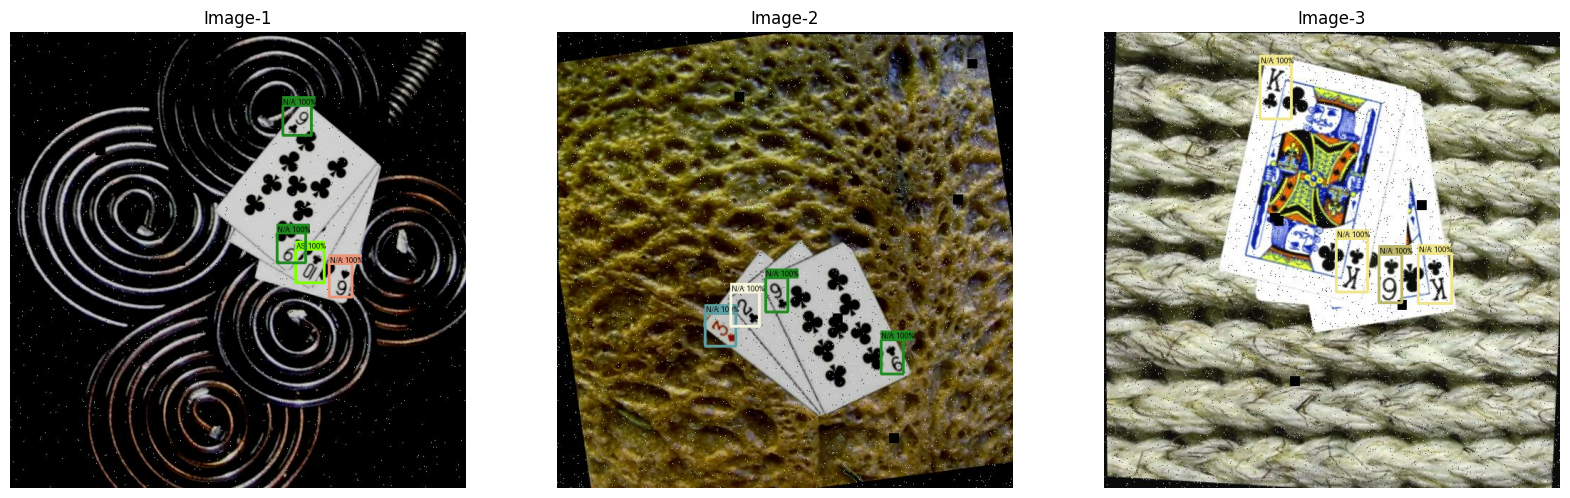

In [27]:
buffer_size = 20
num_of_examples = 3

raw_records = tf.data.TFRecordDataset(
    exp_config.task.train_data.input_path).shuffle(
        buffer_size=buffer_size).take(num_of_examples)
show_batch(raw_records, num_of_examples)

In [ ]:
model, eval_logs = tfm.core.train_lib.run_experiment(
    distribution_strategy=distribution_strategy,
    task=task,
    mode='train_and_eval',
    params=exp_config,
    model_dir=model_dir,
    run_post_eval=True)

restoring or initializing model...
INFO:tensorflow:Customized initialization is done through the passed `init_fn`.


INFO:tensorflow:Customized initialization is done through the passed `init_fn`.


train | step:      0 | training until step 100...


In [ ]:
%load_ext tensorboard
%tensorboard --logdir './trained_model/'

In [ ]:
export_saved_model_lib.export_inference_graph(
    input_type='image_tensor',
    batch_size=1,
    input_image_size=[HEIGHT, WIDTH],
    params=exp_config,
    checkpoint_path=tf.train.latest_checkpoint(model_dir),
    export_dir=export_dir)

In [ ]:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: the file path to the image

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  image = None
  if(path.startswith('http')):
    response = urlopen(path)
    image_data = response.read()
    image_data = BytesIO(image_data)
    image = Image.open(image_data)
  else:
    image_data = tf.io.gfile.GFile(path, 'rb').read()
    image = Image.open(BytesIO(image_data))

  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (1, im_height, im_width, 3)).astype(np.uint8)



def build_inputs_for_object_detection(image, input_image_size):
  """Builds Object Detection model inputs for serving."""
  image, _ = resize_and_crop_image(
      image,
      input_image_size,
      padded_size=input_image_size,
      aug_scale_min=1.0,
      aug_scale_max=1.0)
  return image

In [ ]:
num_of_examples = 3

test_ds = tf.data.TFRecordDataset(
    './tfRecords/test-00000-of-00001.tfrecord').take(
        num_of_examples)
show_batch(test_ds, num_of_examples)

In [ ]:
imported = tf.saved_model.load(export_dir)
model_fn = imported.signatures['serving_default']

In [ ]:
input_image_size = (HEIGHT, WIDTH)
plt.figure(figsize=(20, 20))
min_score_thresh = 0.30 # Change minimum score for threshold to see all bounding boxes confidences.

for i, serialized_example in enumerate(test_ds):
  plt.subplot(1, 3, i+1)
  decoded_tensors = tf_ex_decoder.decode(serialized_example)
  image = build_inputs_for_object_detection(decoded_tensors['image'], input_image_size)
  image = tf.expand_dims(image, axis=0)
  image = tf.cast(image, dtype = tf.uint8)
  image_np = image[0].numpy()
  result = model_fn(image)
  visualization_utils.visualize_boxes_and_labels_on_image_array(
      image_np,
      result['detection_boxes'][0].numpy(),
      result['detection_classes'][0].numpy().astype(int),
      result['detection_scores'][0].numpy(),
      category_index=category_index,
      use_normalized_coordinates=False,
      max_boxes_to_draw=200,
      min_score_thresh=min_score_thresh,
      agnostic_mode=False,
      instance_masks=None,
      line_thickness=4)
  plt.imshow(image_np)
  plt.axis('off')

plt.show()